# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

2024-10-19 16:24:17.136208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-19 16:24:20.703932: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-19 16:24:20.706356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-19 16:24:20.760560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-10-19 16:24:20.761675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
sd_test = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
exper_type = 'dynamics'
adaptive = False

# Length = 6, teacher state dim = 1, student state dim = 10

## Shared setup

In [3]:
epochs_after_opt = 5000
seed = 4541
teacher_state_dim = 1
teacher_mlp_dim = 15
teacher_depth = 2
student_state_dim = 10
student_mlp_dim = 15
student_depth = 2
sd_A = 0.01
sd_B_C = 0.01
sd_D = 0.03
length = 6
ext_length = 40
n_baseline = 20
n_special = 20
n_test = 2000
eps = 0.05
diff = 0.05 / np.exp(0.5 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0, mlp_dim=teacher_mlp_dim, depth=teacher_depth)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
D_in = np.ones((1, teacher_mlp_dim))
D_hidden = np.eye(teacher_mlp_dim)
D_out = np.zeros((teacher_mlp_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
D_out[:, :] = 0.5
set_ssm_weights(teacher,[A, B, C, [D_in] + [D_hidden for i in range(teacher_depth-1)] + [D_out]])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0, mlp_dim=teacher_mlp_dim, depth=teacher_depth)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2024-10-19 16:24:20.819049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 16:24:20.821038: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-19 16:24:20.821859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-10-19 16:24:20.821913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-19 16:24:20.821945: I tensorflow/stream_executor/

## 20 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM + MLP,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = np.random.normal(0, sd_test, (n_test, ext_length, 1))
ext_outputs = ext_teacher(ext_inputs)

2024-10-19 16:24:21.887517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2024-10-19 16:24:22.332102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-19 16:24:22.356033: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 48.91441345214844
7 absolute largest EVs of A: [0.01807914 0.01438873 0.00980635 0.00793589 0.0067946  0.00550804 0.00461668]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 48.91441345214844
7 absolute largest EVs of A: [0.02011525 0.01488584 0.0098196  0.0080637  0.0068142  0.00552601 0.00461911]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.07416246086359024
7 absolute largest EVs of A: [0.9527796  0.06781691 0.0097826  0.00729268 0.00595256 0.0057649  0.00469195]
+-------------+
|Final results|
+-------------+
Train loss: 1.0666246531843004e-12
7 absolute largest EVs of A: [0.999

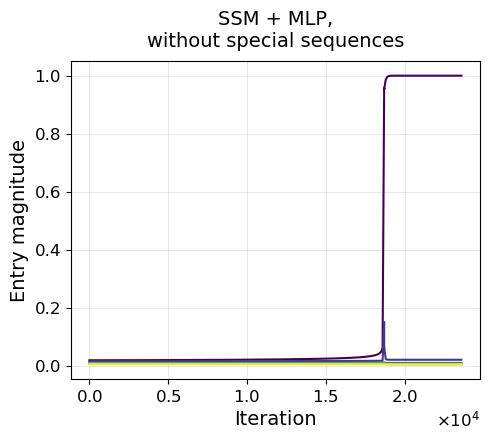

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, mlp_dim=student_mlp_dim, depth=student_depth, sd_D=sd_D, log_period=log_period, 
      print_period=print_period, n_evals=n_evals, epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 20 baseline inputs, 20 special inputs

In [8]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM + MLP,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = np.random.normal(0, sd_test, (n_test, ext_length, 1))
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 56.03889083862305
7 absolute largest EVs of A: [0.01807853 0.01438839 0.00980632 0.00793534 0.00679447 0.00550781 0.00461663]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.04703503102064133
7 absolute largest EVs of A: [1.0152681  1.0043237  0.9921903  0.98795027 0.9836219  0.98343146 0.9755613 ]
+-------------+
|Final results|
+-------------+
Train loss: 4.217807145323604e-06
7 absolute largest EVs of A: [1.0293658  1.0183349  1.0061408  1.0018128  0.9974187  0.99727154 0.9892679 ]
------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

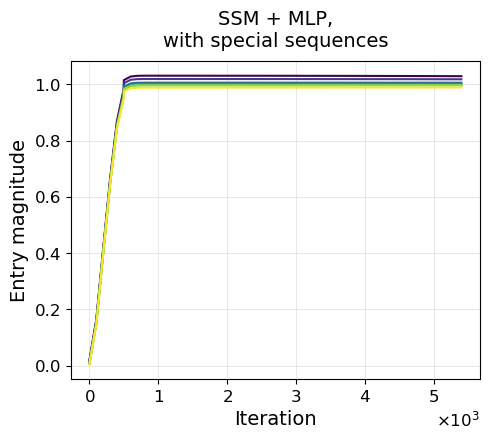

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, mlp_dim=student_mlp_dim, depth=student_depth, sd_D=sd_D, log_period=log_period, 
      print_period=print_period, n_evals=n_evals, epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

# Length = 10, teacher state dim = 1, student state dim = 20

## Shared setup

In [11]:
seed = 4542
teacher_state_dim = 1
teacher_mlp_dim = 25
teacher_depth = 2
student_state_dim = 20
student_mlp_dim = 25
student_depth = 2
sd_A = 0.001
sd_B_C = 0.001
sd_D = 0.1
length = 10
ext_length = 40
n_baseline = 20
n_special = 20
n_test = 2000
eps = 0.05
diff = 0.05 / np.exp(2 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0, mlp_dim=teacher_mlp_dim, depth=teacher_depth)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
D_in = np.ones((1, teacher_mlp_dim))
D_hidden = np.eye(teacher_mlp_dim)
D_out = np.zeros((teacher_mlp_dim, 1))
A[0, 0] = 1
B[0, 0] = 1
C[0, 0] = 1
D_out[:, :] = 0.5
set_ssm_weights(teacher,[A, B, C, [D_in] + [D_hidden for i in range(teacher_depth-1)] + [D_out]])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0, mlp_dim=teacher_mlp_dim, depth=teacher_depth)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 20 baseline inputs, 0 special inputs

In [13]:
epochs_after_opt = 20000
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM + MLP,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = np.random.normal(0, sd_test, (n_test, ext_length, 1))
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 1225.245361328125
7 absolute largest EVs of A: [0.00182258 0.00169867 0.00124764 0.00123773 0.00099863 0.00081393 0.00067051]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 1225.245361328125
7 absolute largest EVs of A: [0.00163896 0.00119452 0.00092897 0.00076053 0.00074303 0.00057927 0.00057245]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 20000
Train loss: 1225.245361328125
7 absolute largest EVs of A: [0.00195092 0.00123631 0.00089963 0.00075525 0.00067714 0.00056465 0.00055913]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 30000
Train loss: 1225.245361328125
7 absolute largest EVs of A: [0.00360978 0.00130621 0.000875

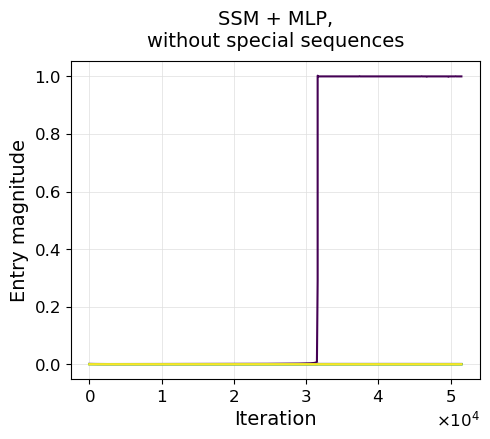

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, mlp_dim=student_mlp_dim, depth=student_depth, sd_D=sd_D, log_period=log_period, 
      print_period=print_period, n_evals=n_evals, epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)

## 20 baseline inputs, 20 special inputs

In [16]:
epochs_after_opt = 5000
base_lr = 0.00005
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length, :] = 1
title = 'SSM + MLP,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = np.random.normal(0, sd_test, (n_test, ext_length, 1))
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 677.3370361328125
7 absolute largest EVs of A: [0.00181959 0.00169757 0.00124657 0.00123726 0.00099615 0.0008136  0.00066984]
-------------------------------------------------------
-------------------------------------------------------
Epoch: 10000
Train loss: 109.4843978881836
7 absolute largest EVs of A: [0.8642784  0.8615312  0.86077917 0.860509   0.8566248  0.8164094  0.80636126]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.049811653792858124
7 absolute largest EVs of A: [1.0027528  0.99982333 0.99934965 0.9987242  0.99092406 0.8453391  0.830006  ]
+-------------+
|Final results|
+-------------+
Train loss: 0.0011128699406981468
7 absolute largest EVs of A: [1.006

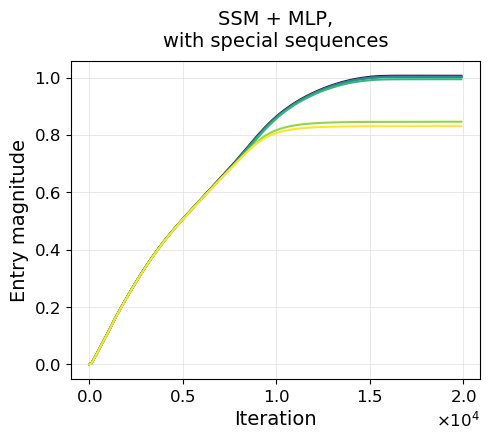

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=adaptive, mlp_dim=student_mlp_dim, depth=student_depth, sd_D=sd_D, log_period=log_period, 
      print_period=print_period, n_evals=n_evals, epochs_after_opt=epochs_after_opt, exper_type=exper_type, title=title)